In [ ]:
# Sequence Classification deals with predicting a major based on the the courses finished. 
# This can be added as a new feature to the existing VAA recommendation engine. 

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model,Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Flatten
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

seed = 7
np.random.seed(seed)
import warnings
warnings.filterwarnings("ignore")


In [22]:
df = pd.read_csv('ClassesMay19-2.csv')

In [23]:
df.head()

,Unnamed: 0,0,1,2,3,4
0,1,[1],"['ENGL&230', 'MATH261', 'ENGR&215', 'HUM&101',...","[4, 1, 1, 1, 2, 2, 2, 3, 3, 3]",['Mechanical Engineering'],['Washington State University']
1,2,[2],"['ENGR121', 'ENGR201', 'ENGR&224', 'ENGR&114',...","[4, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4]",['Mechanical Engineering'],['Washington State University']
2,3,[3],"['MATH&151', 'CHEM&161', 'ENGR121', 'MATH&152'...","[3, 3, 3, 4, 4, 4, 1, 1, 1, 1, 2, 2, 2, 2, 2, ...",['Mechanical Engineering'],['Washington State University']
3,4,[4],"['MATH260', 'ENGR121', 'ENGR201', 'ENGR&215', ...","[1, 1, 1, 2, 2, 2, 3, 3, 3]",['Mechanical Engineering'],['Washington State University']
4,5,[5],"['MATH261', 'ENGR&204', 'ENGR&215', 'ENGR&224'...","[4, 4, 1, 1, 1, 2, 2, 2, 2, 3, 3]",['Mechanical Engineering'],['Washington State University']


In [24]:
df.drop(['2', 'Unnamed: 0','0','4'],axis=1,inplace=True)
df.head()

,1,3
0,"['ENGL&230', 'MATH261', 'ENGR&215', 'HUM&101',...",['Mechanical Engineering']
1,"['ENGR121', 'ENGR201', 'ENGR&224', 'ENGR&114',...",['Mechanical Engineering']
2,"['MATH&151', 'CHEM&161', 'ENGR121', 'MATH&152'...",['Mechanical Engineering']
3,"['MATH260', 'ENGR121', 'ENGR201', 'ENGR&215', ...",['Mechanical Engineering']
4,"['MATH261', 'ENGR&204', 'ENGR&215', 'ENGR&224'...",['Mechanical Engineering']


In [25]:
df.info()
# we have 186 plans right now

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 2 columns):
1    295 non-null object
3    295 non-null object
dtypes: object(2)
memory usage: 4.7+ KB


In [26]:
df = df.rename(index = str,columns={"1":"Courses","3":"MajorPref"})
df = df.replace("['Computer Science and Software Engineering']","['Computer Science']")
df = df.replace("['Computer Engineering']","['Computer Science']")
df = df.replace("['Pre-Engineering – Mechanical, Civil, Aeronautical, Industrial, Materials Science']","['Civil Engineering']")
df = df.replace("['Pre-Engineering – General Engineering Transfer']","['General Major']")




In [27]:
# df.iloc[-4] 

In [28]:
df = df.drop(df.index[[186,214]])

In [29]:
df[df.isnull().any(axis=1)].head()

,Courses,MajorPref


In [30]:
# number of courses(words) in each plan
df['token_length'] = [len(x.split(", ")) for x in df.Courses]
max(df.token_length)
# maximum number of courses of all the plans

71

In [31]:
# The plan with maximum number of courses
df["Courses"] = df["Courses"].str.strip()

df['Courses'] = df['Courses'].map(lambda x: x.lstrip("[").rstrip("]"))

df.loc[df.token_length.idxmax(),'Courses']
# print(df['Courses'])

"'ENGR108', 'MATH&142', 'ENGR111', 'MATH&151', 'CHEM&140', 'MATH&152', 'CHEM&161', 'ENGL&230', 'MATH&163', 'CHEM&162', 'PHYS&114', 'MATH260', 'PHYS&241', 'ENGR121', 'MATH261', 'PHYS&242', 'ENGR&214', 'ENGR&224', 'PHYS&243', 'ENGR&215', 'ENGR&225', 'ENGR240', 'ENGR&204', 'MATH&141', 'CHEM&161', 'ENGR&114', 'MATH&142', 'PHYS&114', 'MATH&151', 'CHEM&162', 'ENGR121', 'MATH&152', 'PHYS&241', 'ENGL&230', 'PHYS130', 'MATH&163', 'PHYS&242', 'ENGR&214', 'MATH260', 'PHYS&243', 'ENGR&215', 'ENGR&225', 'ENGR240', 'MATH261', 'ENGR&204', 'ENGR&224', 'ENGR298', 'MATH&141', 'CHEM&161', 'ENGR&114', 'MATH&142', 'PHYS&114', 'MATH&151', 'CHEM&162', 'ENGR121', 'MATH&152', 'PHYS&241', 'ENGL&230', 'PHYS130', 'MATH&163', 'PHYS&242', 'ENGR&214', 'MATH260', 'PHYS&243', 'ENGR&215', 'ENGR&225', 'ENGR240', 'MATH261', 'ENGR&204', 'ENGR&224', 'ENGR298'"

In [32]:
# Class distribution
# The classes are heavily unbalanced 
# They need to be balanced
df.MajorPref.value_counts()

['Mechanical Engineering']     154
['Computer Science']            30
['General Major']               30
['Electrical Engineering']      29
['Civil Engineering']           14
['Pharmacy']                     8
['Business']                     8
['Graphic Design']               5
['Nursing']                      5
['Chemical Engineering']         5
['Aeronautics Engineering']      5
Name: MajorPref, dtype: int64

Text(0.5,1,'Major Distribution')

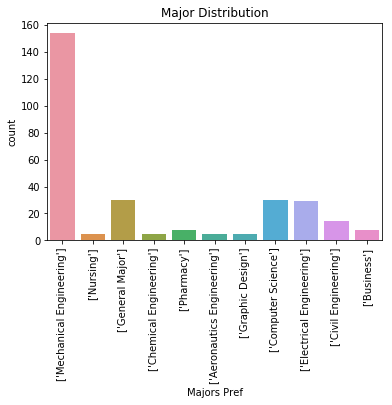

In [33]:
sns.countplot(df.MajorPref)
plt.xlabel('Majors Pref')
plt.xticks(rotation=90)
plt.title('Major Distribution')

In [34]:
majorsPref = df.groupby("MajorPref")

# Summary statistic of all countries
majorsPref.describe()


token_length                                     \
                                   count       mean        std   min    25%   
MajorPref                                                                     
['Aeronautics Engineering']          5.0  22.200000   0.447214  22.0  22.00   
['Business']                         8.0  18.125000   1.552648  17.0  17.00   
['Chemical Engineering']             5.0  12.800000   0.447214  12.0  13.00   
['Civil Engineering']               14.0  17.857143  15.737545   5.0  13.00   
['Computer Science']                30.0  12.300000   6.828692   5.0  10.00   
['Electrical Engineering']          29.0  20.896552   7.997075   4.0  16.00   
['General Major']                   30.0   8.566667   6.061087   1.0   4.00   
['Graphic Design']                   5.0   5.000000   0.000000   5.0   5.00   
['Mechanical Engineering']         154.0  15.006494  10.036858   1.0   6.00   
['Nursing']                          5.0  15.000000   0.000000  15.0  15.00   
['Pharmacy']                         8.0  18.875000   4.257347  12.0  18.75   

                                                
                              50%    75%   max  
MajorPref                                       
['Aeronautics Engineering']  22.0  22.00  23.0  
['Business']                 17.0  20.00  20.0  
['Chemical Engineering']     13.0  13.00  13.0  
['Civil Engineering']        14.0  17.25  71.0  
['Computer Science']         10.0  14.00  33.0  
['Electrical Engineering']   21.0  28.00  42.0  
['General Major']             7.5  14.75  22.0  
['Graphic Design']            5.0   5.00   5.0  
['Mechanical Engineering']   13.0  23.00  66.0  
['Nursing']                  15.0  15.00  15.0  
['Pharmacy']                 21.0  21.00  22.0

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
import re

def tokenize(text):
    return(text.split(re.compile()))

cvec = CountVectorizer(token_pattern ='(\w+\W\d+)')
cvec.fit(df.Courses)
# vocab = cvec.get_feature_names()

# required_list = []
# for word in vocab:
#     required_list.extend(word.split())
# print(required_list)


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(\\w+\\W\\d+)', tokenizer=None,
        vocabulary=None)

In [36]:
len(cvec.get_feature_names())

77

In [37]:

import seaborn as sns

me_doc_matrix = cvec.transform(df[df.MajorPref == "['Mechanical Engineering']"].Courses)
gm_doc_matrix = cvec.transform(df[df.MajorPref == "['General Major']"].Courses)
cs_doc_matrix = cvec.transform(df[df.MajorPref == "['Computer Science']"].Courses)
ee_doc_matrix = cvec.transform(df[df.MajorPref == "['Electrical Engineering']"].Courses)
ph_doc_matrix = cvec.transform(df[df.MajorPref == "['Pharmacy']"].Courses)
nu_doc_matrix = cvec.transform(df[df.MajorPref == "['Nursing']"].Courses)
gd_doc_matrix = cvec.transform(df[df.MajorPref == "['Graphic Design']"].Courses)
ae_doc_matrix = cvec.transform(df[df.MajorPref == "['Aeronautics Engineering']"].Courses)
ce_doc_matrix = cvec.transform(df[df.MajorPref == "['Chemical Engineering']"].Courses)
# co_doc_matrix = cvec.transform(df[df.MajorPref == "['Computer Engineering']"].Courses)
# cse_doc_matrix = cvec.transform(df[df.MajorPref == "['Computer Science and Software Engineering']"].Courses)


me_tf = np.sum(me_doc_matrix,axis=0)
gm_tf = np.sum(gm_doc_matrix,axis=0)
cs_tf = np.sum(cs_doc_matrix,axis=0)
ee_tf = np.sum(ee_doc_matrix,axis=0)
ph_tf = np.sum(ph_doc_matrix,axis=0)
nu_tf = np.sum(nu_doc_matrix,axis=0)
gd_tf = np.sum(gd_doc_matrix,axis=0)
ae_tf = np.sum(ae_doc_matrix,axis=0)
ce_tf = np.sum(ce_doc_matrix,axis=0)
# co_tf = np.sum(co_doc_matrix,axis=0)
# cse_tf = np.sum(cse_doc_matrix,axis=0)

me = np.squeeze(np.asarray(me_tf))
gm = np.squeeze(np.asarray(gm_tf))
cs = np.squeeze(np.asarray(cs_tf))
ee = np.squeeze(np.asarray(ee_tf))
ph = np.squeeze(np.asarray(ph_tf))
nu = np.squeeze(np.asarray(nu_tf))
gd = np.squeeze(np.asarray(gd_tf))
ae = np.squeeze(np.asarray(ae_tf))
ce = np.squeeze(np.asarray(ce_tf))
# co = np.squeeze(np.asarray(co_tf))
# cse = np.squeeze(np.asarray(cse_tf))


term_freq_df = pd.DataFrame([me,gm,cs,ee,ph,nu,gd,ae,ce],columns=cvec.get_feature_names()).transpose()


term_freq_df.columns = ['me','gm','cs','ee','ph','nu','gd','ae','ce']
term_freq_df['total']= term_freq_df['me']+term_freq_df['gm']+term_freq_df['cs']+term_freq_df['ee']+term_freq_df['ph']+term_freq_df['nu']+term_freq_df['gd']+term_freq_df['ae']+term_freq_df['ce']
term_freq_df.sort_values(by='total', ascending=False).iloc[:8]
print(term_freq_df)



          me  gm  cs  ee  ph  nu  gd  ae  ce  total
acct&201   0   0   0   0   0   0   0   0   0      0
acct&202   0   0   0   0   0   0   0   0   0      0
acct&203   0   0   0   0   0   0   0   0   0      0
anth&206  28   0   0   0   0   0   0   0   0     28
anth&215   1   0   0   0   0   0   0   0   0      1
biol&100   0   0   1   0   0   0   0   0   0      1
biol&211   0   5   0   0   1   5   0   0   0     11
biol&221   0   0   0   0   5   0   0   0   0      5
biol&222   0   0   0   0   6   0   0   0   4     10
biol&223   0   0   0   0   6   0   0   0   0      6
biol&231   0   5   0   0   6   5   0   0   0     16
biol&232   0   5   0   0   6   5   0   0   0     16
biol&260   0   5   0   0   6   5   0   0   0     16
bus&101    1   0   0   0   0   0   0   0   0      1
bus&201    0   0   0   0   0   0   0   0   0      0
chem&121   1  11   0   0   0   5   0   0   0     17
chem&131   0   0   0   0   0   5   0   0   0      5
chem&140  28   6   5  10   8   0   0   5   0     62
chem&161  80

In [38]:
def barplot(x_data, y_data, x_label="", y_label="", title=""):
    fig, ax = plt.subplots()
    # Draw bars, position them in the center of the tick mark on the x-axis
    ax.bar(x_data, y_data, color = '#539caf', align = 'center')
    # Draw error bars to show standard deviation, set ls to 'none'
    # to remove line between points
#     ax.errorbar(x_data, y_data, yerr = error_data, color = '#297083', ls = 'none', lw = 2, capthick = 2)
    fig = plt.figure(figsize=(400,400))
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_xticklabels(x_data,rotation=90)
#     fig.set_label_position("top")
#     fig = plt.xticks(rotation='vertical')
#     plt.xticks(rotation=45)
    ax.set_title(title)

In [39]:
term_freq_df.sort_values(by='total', ascending=False)

,me,gm,cs,ee,ph,nu,gd,ae,ce,total
phys&241,89,6,22,21,0,0,0,5,5,148
phys&243,92,12,6,25,0,0,0,5,5,145
math&151,83,8,24,14,8,0,0,5,0,142
phys&242,90,12,6,23,0,0,0,5,5,141
math&163,73,9,15,26,0,0,0,5,5,133
engr&215,110,7,1,7,0,0,0,5,0,130
chem&161,80,6,7,20,8,0,0,5,0,126
math&152,69,8,22,21,0,0,0,5,0,125
math&264,68,8,3,24,0,0,0,5,10,118
engr&225,102,7,1,2,0,0,0,5,0,117


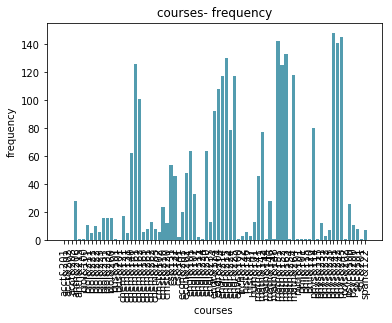

<Figure size 28800x28800 with 0 Axes>

In [40]:
barplot(cvec.get_feature_names(),term_freq_df['total'],"courses ","frequency","courses- frequency")

In [41]:
from wordcloud import WordCloud
def get_word_cloud(major):
    course = df[df.MajorPref == major]
    course_string = []
    for t in course.Courses:
#     t=t[1:len(t)-1]
        course_string = course_string + t.split("', ''")

    course_string = pd.Series(course_string).str.cat(sep=',')
# print(course_string)
    words = course_string.split(",")
    comment_words =""

    for i in range(len(words)):
        words[i] = words[i].lstrip("'").rstrip("'") 
    for w in words: 
        comment_words = w+comment_words
    wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(comment_words)
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# print(comment_words)

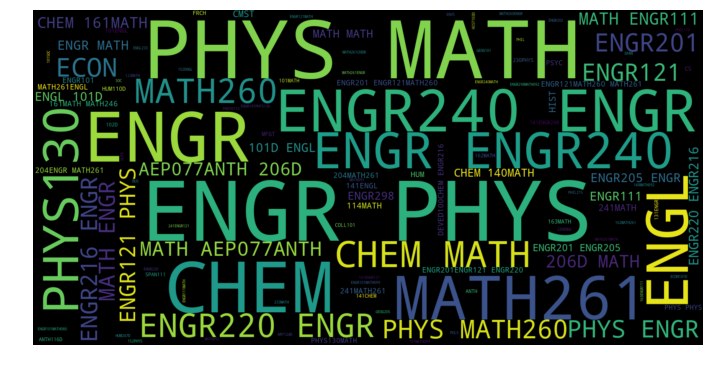

In [42]:
major = "['Mechanical Engineering']"
get_word_cloud(major)




Text(0.5,1,'Top Courses')

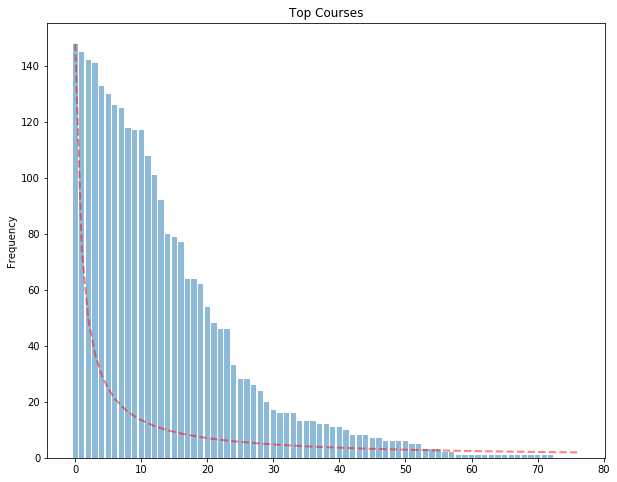

In [43]:
# zipf

y_pos = np.arange(77)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top Courses')

stop_words : are the words which do not add any meaning to the document. Since in this document, we dont have any such words, we selected the stop_words = none. 


TF IDF is a crude but effective way of distilling documents down to a reasonable and manageable abstraction. However, trade off is this process removes a lot of the semantic information that was in the document, such as Entities (“West Virginia”) and word ordering “toy dog” vs “dog toy” and distances between words.


For unique word in each document, count how many times it shows up in that document. That's “Term Frequency” (TF)

Then, take that unique word and count how many times it shows up in all documents. That's “Document Frequency” (DF)

You can massage DF but next, you divide TF by modified DF (Inverse DF) for each word.

The vectorization part is building a big Vector consisting of each unique word, which is potentially large (tens of thousands of unique words).

Now, if you have a query document, you can build its TF-IDF Vector and find the documents with TF-IDF from the corpus that's “nearest” to the query document. Or use the Vectors to cluster the documents.

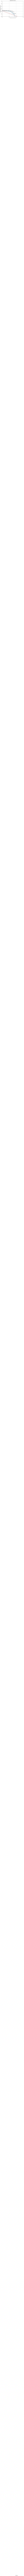

In [44]:
from pylab import *
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**3)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for Courses")
xlabel("Frequency rank of course")
ylabel("Absolute frequency of course")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 10).astype(int)):
    dummy = text(ranks[n], frequencies[n], tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

# Confusion Matrix and Splitting

In [45]:
x = df.Courses
y = df.MajorPref
from sklearn.cross_validation import train_test_split
SEED = 2000

In [46]:
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)

In [47]:
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

# Logistic Regression without Sampling

In [48]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Confusion matrix'
        else:
            title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.show()
    return ax

In [49]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
# Visualize the results in ROC-AUC
def visualize_results(pred_roc,num_classes,y):
    unique, counts = np.unique(pred_roc, return_counts=True)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], pred_roc[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    colors = cycle(['navy', 'turquoise', 'darkorange', 'aqua', 'teal','green','red','black','brown','pink'])
    plt.figure(figsize=(7, 8))
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

    lines.append(l)
    labels.append('iso-f1 curves')

    for i, color in zip(range(num_classes), colors):
        l, = plt.plot(fpr[i], tpr[i], color=color, lw=2)
        lines.append(l)
        labels.append('TPR-FPR for class {0} (area = {1:0.2f})'
                      ''.format(i, roc_auc[i]))

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('FPR-TPR Curve')
    plt.legend(lines, labels, loc=(1, 0), prop=dict(size=14))
    plt.show()


In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, confusion_matrix ,recall_score ,precision_score,f1_score,roc_curve,roc_auc_score
from sklearn.model_selection import cross_val_score

# tf : term frequency
# idf : Inverse  document frequency

tvec = TfidfVectorizer(stop_words=None, max_features=100000, ngram_range=(1, 3))
lr = LogisticRegression()



from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score

def lr_cv(splits, X, Y, pipeline, average_method):
    
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    
    for train, test in kfold.split(X, Y):
        lr_fit = pipeline.fit(X[train], Y[train])
        prediction = lr_fit.predict(X[test])
        scores = lr_fit.score(X[test],Y[test])
        accuracy.append(scores)
        precision.append(precision_score(Y[test], prediction, average=average_method)*100)
        recall.append(recall_score(Y[test], prediction, average=average_method)*100)
        f1.append(f1_score(Y[test], prediction, average=average_method)*100)
        
    classes=["['Aeronautics Engineering']","['Business']","['Chemical Engineering']", "['Civil Engineering']",
                 "['Computer Science']","['Electrical Engineering']","['General Major']","['Graphic Design']","['Mechanical Engineering']",
                 "['Nursing']","['Pharmacy']"]
    print(classification_report(Y[test],prediction))
    plot_confusion_matrix(Y[test],prediction,classes=classes)
    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))
    
    y = label_binarize(Y[test], classes=["['Aeronautics Engineering']",
    "['Business']",
    "['Chemical Engineering']",
    "['Civil Engineering']",
    "['Computer Science']",
    "['Electrical Engineering']",
    "['General Major']",
    "['Graphic Design']",
    "['Mechanical Engineering']",
    "['Nursing']",
    "['Pharmacy']"])
    num_classes = y.shape[1]
    pred_roc = lr_fit.predict_proba(X[test])

    print(visualize_results(pred_roc,num_classes,y))


                             precision    recall  f1-score   support

['Aeronautics Engineering']       0.00      0.00      0.00         1
               ['Business']       1.00      1.00      1.00         1
   ['Chemical Engineering']       1.00      1.00      1.00         1
      ['Civil Engineering']       0.00      0.00      0.00         2
       ['Computer Science']       1.00      0.83      0.91         6
 ['Electrical Engineering']       1.00      0.40      0.57         5
          ['General Major']       1.00      0.33      0.50         6
         ['Graphic Design']       1.00      1.00      1.00         1
 ['Mechanical Engineering']       0.71      1.00      0.83        30
                ['Nursing']       1.00      1.00      1.00         1
               ['Pharmacy']       0.00      0.00      0.00         1

                avg / total       0.77      0.78      0.73        55

Confusion matrix
[[ 0  0  0  0  0  0  0  0  1  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  1 

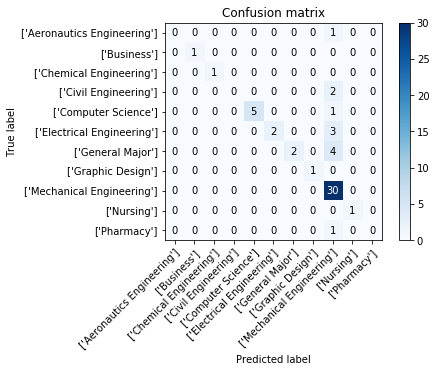

accuracy: 0.78% (+/- 0.03%)
precision: 72.91% (+/- 7.11%)
recall: 63.09% (+/- 8.31%)
f1 score: 65.41% (+/- 8.51%)


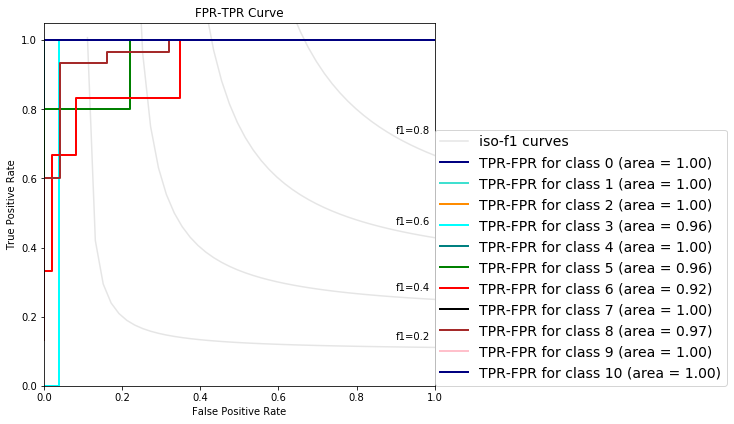

None


In [51]:

from sklearn.pipeline import Pipeline
original_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', lr)
])
lr_cv(5, df.Courses, df.MajorPref, original_pipeline, 'macro')

### Logistic Regression with OverSampling with Testing and Training

In [52]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
ROS_pipeline = make_pipeline(tvec, RandomOverSampler(random_state=777),lr)



In [53]:
# Create input and output vectors.
# Process the labels.

X = df.Courses
Y = df.MajorPref
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)


In [54]:
# Split into training and test data.

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.10)




In [55]:
tv = TfidfVectorizer(stop_words=None, max_features=40)
testing_tfidf = tv.fit_transform(X_test)
ros = RandomOverSampler(random_state=777)
X_ROS, y_ROS = ros.fit_sample(testing_tfidf, Y_test)
pd.DataFrame(testing_tfidf.todense(), columns=tv.get_feature_names())


,101,114,131,132,140,142,151,152,161,162,...,engr201,engr205,engr216,engr220,engr240,math,math260,math261,phys,phys130
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.345888,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.281425,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.292987,0.000000,0.332609,0.000000,0.188501,0.000000,0.188501,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.299721,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.705464,0.299721,0.000000,0.000000,0.000000
3,0.708299,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.432109,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.749353,0.000000
5,0.000000,0.142762,0.197893,0.197893,0.197893,0.000000,0.000000,0.000000,0.137275,0.000000,...,0.000000,0.242403,0.000000,0.000000,0.127320,0.199785,0.127320,0.142762,0.457575,0.000000
6,0.000000,0.000000,0.271971,0.271971,0.000000,0.257375,0.168732,0.174980,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.549143,0.000000,0.000000,0.157215,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.217574,0.000000,0.000000,0.139982,0.150927,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.139982,0.329482,0.139982,0.000000,0.377312,0.178049
8,0.000000,0.130635,0.181082,0.181082,0.181082,0.000000,0.112344,0.116504,0.125613,0.000000,...,0.000000,0.221810,0.000000,0.000000,0.116504,0.365626,0.116504,0.130635,0.418703,0.148186
9,0.000000,0.119458,0.000000,0.000000,0.000000,0.000000,0.102732,0.106536,0.114866,0.135508,...,0.165589,0.202833,0.187982,0.156702,0.106536,0.334344,0.106536,0.119458,0.287160,0.135508


In [56]:
pd.DataFrame(X_ROS.todense(), columns=tv.get_feature_names())

,101,114,131,132,140,142,151,152,161,162,...,engr201,engr205,engr216,engr220,engr240,math,math260,math261,phys,phys130
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.345888,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.281425,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.292987,0.000000,0.332609,0.000000,0.188501,0.000000,0.188501,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.299721,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.705464,0.299721,0.000000,0.000000,0.000000
3,0.708299,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.432109,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.749353,0.000000
5,0.000000,0.142762,0.197893,0.197893,0.197893,0.000000,0.000000,0.000000,0.137275,0.000000,...,0.000000,0.242403,0.000000,0.000000,0.127320,0.199785,0.127320,0.142762,0.457575,0.000000
6,0.000000,0.000000,0.271971,0.271971,0.000000,0.257375,0.168732,0.174980,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.549143,0.000000,0.000000,0.157215,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.217574,0.000000,0.000000,0.139982,0.150927,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.139982,0.329482,0.139982,0.000000,0.377312,0.178049
8,0.000000,0.130635,0.181082,0.181082,0.181082,0.000000,0.112344,0.116504,0.125613,0.000000,...,0.000000,0.221810,0.000000,0.000000,0.116504,0.365626,0.116504,0.130635,0.418703,0.148186
9,0.000000,0.119458,0.000000,0.000000,0.000000,0.000000,0.102732,0.106536,0.114866,0.135508,...,0.165589,0.202833,0.187982,0.156702,0.106536,0.334344,0.106536,0.119458,0.287160,0.135508


In [57]:
y_ROS

array([8, 8, 8, 8, 6, 5, 4, 6, 5, 8, 3, 8, 8, 8, 4, 8, 8, 8, 8, 4, 8, 8,
       8, 8, 4, 8, 6, 8, 8, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

                             precision    recall  f1-score   support

['Aeronautics Engineering']       1.00      1.00      1.00         1
               ['Business']       1.00      1.00      1.00         1
   ['Chemical Engineering']       1.00      1.00      1.00         1
      ['Civil Engineering']       1.00      1.00      1.00         2
       ['Computer Science']       0.86      1.00      0.92         6
 ['Electrical Engineering']       0.80      0.80      0.80         5
          ['General Major']       0.80      0.67      0.73         6
         ['Graphic Design']       1.00      1.00      1.00         1
 ['Mechanical Engineering']       0.97      0.97      0.97        30
                ['Nursing']       1.00      1.00      1.00         1
               ['Pharmacy']       1.00      1.00      1.00         1

                avg / total       0.93      0.93      0.93        55

Confusion matrix
[[ 1  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  1 

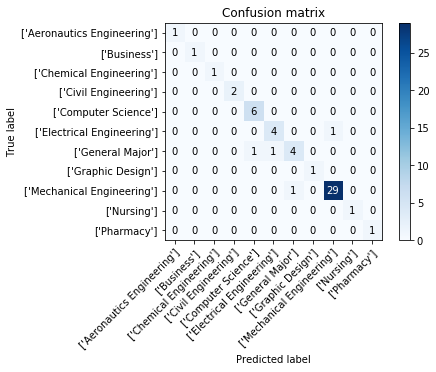

accuracy: 0.90% (+/- 0.04%)
precision: 92.05% (+/- 3.58%)
recall: 92.57% (+/- 3.72%)
f1 score: 91.68% (+/- 3.06%)


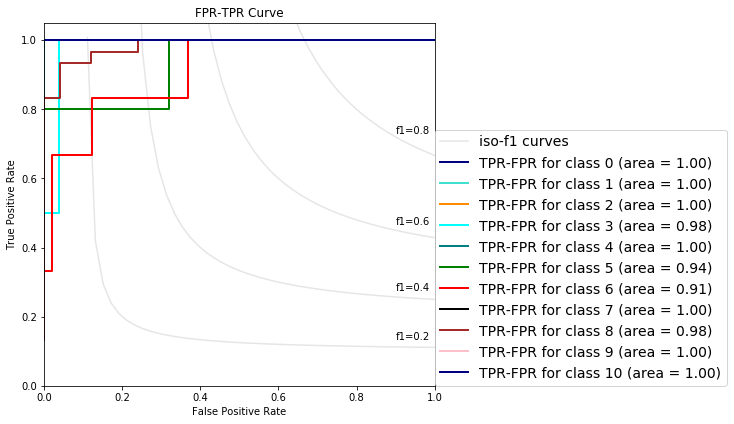

None


In [58]:
lr_cv(5, df.Courses, df.MajorPref, ROS_pipeline, 'macro')

### SVM with OverSampling with Testing and Training

In [81]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from sklearn.svm import SVC

clf = SVC(kernel = 'linear',degree = 10,probability = True)
ROS_pipeline = make_pipeline(tvec, RandomOverSampler(random_state=777),clf)

In [82]:
def svm_cv(splits, X, Y, pipeline,average_method):
    
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    
    for train, test in kfold.split(X, Y):
        svm_fit = pipeline.fit(X[train], Y[train])
        prediction = svm_fit.predict(X[test])
        scores = svm_fit.score(X[test],Y[test])
        accuracy.append(scores * 100)
        precision.append(precision_score(Y[test], prediction, average=average_method)*100)
        recall.append(recall_score(Y[test], prediction, average=average_method)*100)
        f1.append(f1_score(Y[test], prediction, average=average_method)*100)
        
    classes=["['Aeronautics Engineering']","['Business']","['Chemical Engineering']", "['Civil Engineering']",
                 "['Computer Science']","['Electrical Engineering']","['General Major']","['Graphic Design']","['Mechanical Engineering']",
                 "['Nursing']","['Pharmacy']"]
    print(classification_report(Y[test],prediction))
    plot_confusion_matrix(Y[test],prediction,classes=classes)
    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))
    
    y = label_binarize(Y[test], classes=["['Aeronautics Engineering']",
    "['Business']",
    "['Chemical Engineering']",
    "['Civil Engineering']",
    "['Computer Science']",
    "['Electrical Engineering']",
    "['General Major']",
    "['Graphic Design']",
    "['Mechanical Engineering']",
    "['Nursing']",
    "['Pharmacy']"])
    num_classes = y.shape[1]
    pred_roc = svm_fit.predict_proba(X[test])

    print(visualize_results(pred_roc,num_classes,y))

In [83]:
X = df.Courses
Y = df.MajorPref
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [84]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.10)

In [85]:
tv = TfidfVectorizer(stop_words=None, max_features=40)
testing_tfidf = tv.fit_transform(X_test)
ros = RandomOverSampler(random_state=777)
X_ROS, y_ROS = ros.fit_sample(testing_tfidf, Y_test)
pd.DataFrame(testing_tfidf.todense(), columns=tv.get_feature_names())

,101,102,114,140,141,142,151,152,161,162,...,engr121,engr201,engr216,engr220,engr240,math,math260,math261,phys,phys130
0,0.000000,0.243380,0.000000,0.000000,0.000000,0.000000,0.000000,0.168828,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.679576,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.119719,0.000000,0.000000,0.135804,0.124662,0.115118,0.130001,0.124662,...,0.000000,0.000000,0.165951,0.165951,0.106769,0.370701,0.106769,0.110813,0.308871,0.188393
2,0.000000,0.349552,0.000000,0.000000,0.000000,0.000000,0.000000,0.242479,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.585622,0.224894,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.111438,0.146182,0.146182,0.126411,0.116039,0.107155,0.121009,0.116039,...,0.116039,0.000000,0.000000,0.000000,0.099384,0.517590,0.099384,0.103148,0.383341,0.000000
4,0.249827,0.000000,0.000000,0.000000,0.000000,0.000000,0.165313,0.152656,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.368688,0.141586,0.000000,0.546121,0.000000
5,0.000000,0.425976,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.315837,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.278214,0.000000,0.000000,0.000000,0.185775,0.345210,0.315837
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.164588,0.185867,0.178234,...,0.178234,0.000000,0.000000,0.000000,0.000000,0.265003,0.152652,0.158434,0.441605,0.269353
8,0.000000,0.092040,0.000000,0.087100,0.087100,0.075320,0.069140,0.000000,0.072101,0.069140,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.154198,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.113828,0.149317,0.149317,0.129122,0.118528,0.109453,0.123604,0.118528,...,0.118528,0.000000,0.000000,0.000000,0.101516,0.528690,0.101516,0.105360,0.391563,0.000000


In [86]:
pd.DataFrame(X_ROS.todense(), columns=tv.get_feature_names())

,101,102,114,140,141,142,151,152,161,162,...,engr121,engr201,engr216,engr220,engr240,math,math260,math261,phys,phys130
0,0.000000,0.243380,0.000000,0.000000,0.000000,0.000000,0.000000,0.168828,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.679576,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.119719,0.000000,0.000000,0.135804,0.124662,0.115118,0.130001,0.124662,...,0.000000,0.000000,0.165951,0.165951,0.106769,0.370701,0.106769,0.110813,0.308871,0.188393
2,0.000000,0.349552,0.000000,0.000000,0.000000,0.000000,0.000000,0.242479,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.585622,0.224894,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.111438,0.146182,0.146182,0.126411,0.116039,0.107155,0.121009,0.116039,...,0.116039,0.000000,0.000000,0.000000,0.099384,0.517590,0.099384,0.103148,0.383341,0.000000
4,0.249827,0.000000,0.000000,0.000000,0.000000,0.000000,0.165313,0.152656,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.368688,0.141586,0.000000,0.546121,0.000000
5,0.000000,0.425976,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.315837,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.278214,0.000000,0.000000,0.000000,0.185775,0.345210,0.315837
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.164588,0.185867,0.178234,...,0.178234,0.000000,0.000000,0.000000,0.000000,0.265003,0.152652,0.158434,0.441605,0.269353
8,0.000000,0.092040,0.000000,0.087100,0.087100,0.075320,0.069140,0.000000,0.072101,0.069140,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.154198,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.113828,0.149317,0.149317,0.129122,0.118528,0.109453,0.123604,0.118528,...,0.118528,0.000000,0.000000,0.000000,0.101516,0.528690,0.101516,0.105360,0.391563,0.000000


                             precision    recall  f1-score   support

['Aeronautics Engineering']       1.00      1.00      1.00         2
               ['Business']       1.00      1.00      1.00         4
   ['Chemical Engineering']       1.00      1.00      1.00         2
      ['Civil Engineering']       0.67      0.29      0.40         7
       ['Computer Science']       0.88      0.93      0.90        15
 ['Electrical Engineering']       0.91      0.71      0.80        14
          ['General Major']       0.86      0.80      0.83        15
         ['Graphic Design']       1.00      1.00      1.00         2
 ['Mechanical Engineering']       0.88      0.96      0.92        77
                ['Nursing']       1.00      1.00      1.00         2
               ['Pharmacy']       1.00      1.00      1.00         4

                avg / total       0.88      0.89      0.88       144

Confusion matrix
[[ 2  0  0  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0  0  0]
 [ 0  0  2 

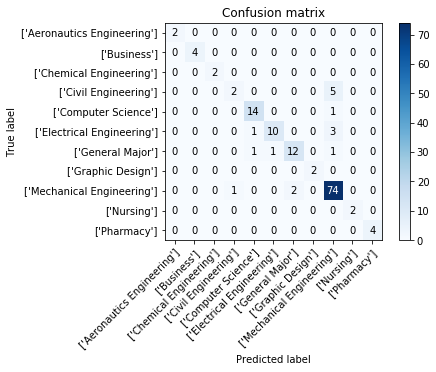

accuracy: 88.74% (+/- 0.15%)
precision: 92.80% (+/- 0.18%)
recall: 89.09% (+/- 0.96%)
f1 score: 90.38% (+/- 0.83%)


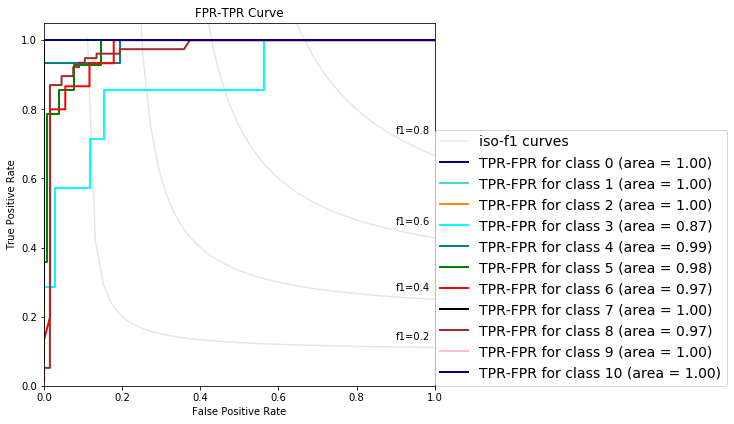

None


In [87]:
svm_cv(2, df.Courses, df.MajorPref, ROS_pipeline,'macro')

# RNN

In [252]:
# Process the data
# Tokenize the data and convert the text to sequences.
# Add padding to ensure that all the sequences have the same shape.
# There are many ways of taking the max_len and here an arbitrary length of 150 is chosen.

max_words = 35
max_len = 35
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)


In [253]:
# RNN
# Define the RNN structure.

def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,40,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [254]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 35)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 35, 40)            1400      
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                26880     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)  

In [255]:
model.fit(sequences_matrix,Y_train,batch_size=64,epochs=5,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Instructions for updating:
Use tf.cast instead.
Train on 210 samples, validate on 53 samples
Epoch 1/5
210/210 [==============================] - 1s 6ms/step - loss: 0.1147 - acc: 0.0286 - val_loss: -5.5187 - val_acc: 0.0000e+00
Epoch 2/5
210/210 [==============================] - 0s 754us/step - loss: -22.9490 - acc: 0.0333 - val_loss: -68.0945 - val_acc: 0.0000e+00
Epoch 3/5
210/210 [==============================] - 0s 739us/step - loss: -74.0318 - acc: 0.0333 - val_loss: -89.9391 - val_acc: 0.0000e+00
Epoch 4/5
210/210 [==============================] - 0s 733us/step - loss: -84.8724 - acc: 0.0333 - val_loss: -89.9391 - val_acc: 0.0000e+00


In [256]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [257]:
accr = model.evaluate(test_sequences_matrix,Y_test)

30/30 [==============================] - 0s 323us/step


In [258]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: -96.717
  Accuracy: 0.033
